In [1]:
import numpy as np
from scipy.linalg import hadamard
import time
import matplotlib.pyplot as plt

In [2]:
def getData(m, n, k, Ameth, xmeth, sigma1=None, sigma2=None, state=None):

    """
    Generates data for compressed sensing problems.

    INPUTS
    m : Number of rows in the matrix A
    n : Number of columns in the matrix A
    k : Number of non-zero elements in the sparse vector xs

    Ameth : determines how A is generated
    0 - randn(m,n)
    1 - randn then columns scaled to unit norm
    2 - randn then QR to get orthonormal rows
    3 - bernoulli +/- 1 distribution
    4 - partial Hadamard matrix


    xmeth : determines how xs is generated
    0 - random permutation for support, 2*randn for values
    1 - random permutation for support, 2*(rand - 0.5) for values
    2 - random permutation for support, ones for values
    3 - random permutation for support, sign(randn) for values

    sigma1 : standard deviation of signal noise (added to xs)
    sigma2 : standard deviation of meas. noise (added to b)
    state : state used to initialize random processes
    """

    if state is not None:
        np.random.seed(state)

    picks = []

    # Generate matrix A based on Ameth
    if Ameth == 0:
        # randn, no scaling
        A = np.random.randn(m, n)

    elif Ameth == 1:
        # randn, column scaling
        A = np.random.randn(m, n)
        for i in range(n):
            A[:, i] /= np.linalg.norm(A[:, i])

    elif Ameth == 2:
        # randn, orthonormal rows
        A = np.random.randn(m, n)
        A, _ = np.linalg.qr(A.T)
        A = A.T

    elif Ameth == 3:
        # bernoulli +/- 1
        A = np.sign(np.random.rand(m, n) - 0.5)
        ind = np.where(A == 0)
        A[ind] = 1

    elif Ameth == 4:
        # partial hadamard
        A = hadamard(n)
        picks = np.random.permutation(n)[:m]
        A = A[picks, :]


    # Generate xs based on xmeth
    p = np.random.permutation(n)
    xs = np.zeros(n)
    if xmeth == 0:
        xs[p[:k]] = 2 * np.random.randn(k)
    elif xmeth == 1:
        xs[p[:k]] = 2 * (np.random.rand(k) - 0.5)
    elif xmeth == 2:
        xs[p[:k]] = np.ones(k)
    elif xmeth == 3:
        xs[p[:k]] = np.sign(np.random.randn(k))
    # ... other cases for xmeth

    # Add noise to xs and xsn
    xsn = xs.copy()
    if sigma1 is not None and sigma1 > 0:
        xsn += np.random.randn(n) * sigma1

    # Get noiseless measurements
    b = np.dot(A, xsn)

    # Add noise to b
    if sigma2 is not None and sigma2 > 0:
        b += np.random.randn(m) * sigma2

    return A, b, xs, xsn, picks

In [3]:
def GM_ls(Q, c, x, lc, verbosity, arls, maxit, eps, fstop, stopcr):
    """
    Implementation of the Gradient Method for minimizing f(x) = 0.5 * ||Qx - c||^2

    INPUTS:
    Q : Q matrix
    c : c term
    x : starting point
    lc : Lipschitz constant of the gradient (not needed if exact/Armijo ls used)
    verbosity : printing level
    arls : line search (1 Armijo 2 exact 3 fixed)
    maxit : maximum number of iterations
    eps : tolerance
    fstop : target o.f. value
    stopcr : stopping condition
    """
    gamma = 0.0001
    maxniter = maxit
    fh = np.zeros(maxit)
    gnrit = np.zeros(maxit)
    timeVec = np.zeros(maxit)
    flagls = 0

    start_time = time.time()
    timeVec[0] = 0

    # Values for the smart computation of the o.f.
    rx = Q @ x - c

    fx = 0.5 * rx @ rx

    it = 1

    while flagls == 0:
        if it == 1:
            timeVec[it - 1] = 0
        else:
            timeVec[it - 1] = time.time() - start_time

        fh[it - 1] = fx

        # Gradient evaluation
        g = Q.T @ rx
        d = -g

        gnr = g @ d
        gnrit[it - 1] = -gnr

        # Stopping criteria and test for termination
        if it >= maxniter:
            break

        if stopcr == 1:
            # Continue if not yet reached target value fstop
            if fx <= fstop:
                break
        elif stopcr == 2:
            # Stopping criterion based on the product of the gradient with the direction
            if abs(gnr) <= eps:
                break
        else:
            raise ValueError('Unknown stopping criterion')

        # Line search
        if arls == 1:
            # Armijo search
            alpha = 1
            ref = gamma * gnr

            while True:
                z = x + alpha * d
                rz = Q @ z - c
                fz = 0.5 * rz @ rz

                if fz <= fx + alpha * ref:
                    z = x + alpha * d
                    break
                else:
                    alpha *= 0.1

                if alpha <= 1e-20:
                    z = x
                    fz = fx
                    flagls = 1
                    it -= 1
                    break

        elif arls == 2:
            # Exact alpha
            den = np.linalg.norm(Q @ d, 2) ** 2
            alpha = -gnr / den
            z = x + alpha * d
            rz = Q @ z - c
            fz = 0.5 * rz @ rz

        else:
            # Fixed alpha
            alpha = 1 / lc
            z = x + alpha * d
            rz = Q @ z - c
            fz = 0.5 * rz @ rz

        x = z
        rx = rz
        fx = fz

        if verbosity > 0:
            print(f'-----------------** {it} **------------------')
            print(f'gnr      = {abs(gnr)}')
            print(f'f(x)     = {fx}')
            print(f'alpha    = {alpha}')

        it += 1

    if it < maxit:
        fh[it - 1:maxit] = fh[it - 2]
        gnrit[it - 1:maxit] = gnrit[it - 2]
        timeVec[it - 1:maxit] = timeVec[it - 2]

    ttot = time.time() - start_time

    return x, it, fx, ttot, fh, timeVec, gnrit

In [4]:
def STGM_ls(Q, c, x, lc, verbosity, nepochs, maxit, eps, fstop, stopcr):
    """
    Implementation of the Stochastic Gradient Method
    for min f(x) = 0.5 * ||Qx - c||^2

    INPUTS:
    Q: Q matrix
    c: c term
    x: starting point
    lc: constant of the reduced stepsize (numerator)
    verbosity: printing level
    maxit: maximum number of iterations
    eps: tolerance
    fstop: target o.f. value
    stopcr: stopping condition
    """

    maxniter = maxit
    fh = np.zeros(maxit)
    gnrit = np.zeros(maxit)
    timeVec = np.zeros(maxit)
    flagls = 0

    start_time = time.time()
    timeVec[0] = 0

    m, n = Q.shape

    # Values for the smart computation of the o.f.
    rx = Q @ x - c
    fx = 0.5 * rx @ rx

    it = 1

    while flagls == 0:
        # Vectors updating
        if it == 1:
            timeVec[it - 1] = 0
        else:
            timeVec[it - 1] = time.time() - start_time
        fh[it - 1] = fx

        # Gradient evaluation
        ind = np.random.randint(m)
        g = (Q[ind, :] @ x - c[ind]) * Q[ind, :].T
        d = -g

        gnr = g @ d
        gnrit[it - 1] = -gnr

        # Stopping criteria and test for termination
        if it >= maxniter:
            break
        if stopcr == 1:
            if fx <= fstop:
                break
        elif stopcr == 2:
            if abs(gnr) <= eps:
                break
        else:
            raise ValueError("Unknown stopping criterion")

        # Reduced alpha
        alpha = np.sqrt(lc / (it + 1))
        z = x + alpha * d
        # Update gradient at the end of epoch (10000 iterations per epoch)
        if it % nepochs == 0:
            rz = Q @ z - c
            fz = 0.5 * np.sum(rz ** 2)
        else:
            rz = rx
            fz = fx

        x = z
        fx = fz
        rx = rz

        if verbosity > 0:
            print(f"-----------------** {it} **------------------")
            print(f"gnr      = {abs(gnr)}")
            print(f"f(x)     = {fx}")
            print(f"alpha    = {alpha}")

        it += 1

    if it < maxit:
        fh[it - 1:maxit] = fh[it - 2]
        gnrit[it - 1:maxit] = gnrit[it - 2]
        timeVec[it - 1:maxit] = timeVec[it - 2]

    ttot = time.time() - start_time

    return x, it, fx, ttot, fh, timeVec, gnrit

In [5]:
def VR_STGM_ls(Q, c, x, lc, verbosity, nepochs, maxit, eps, fstop, stopcr):
    """
    Implementation of the Stochastic Variance Reduction
    Gradient Method
    for min f(x)=0.5 ||Qx-c||^2

    INPUTS:
    Q: Q matrix
    c: c term
    x: starting point
    lc: constant of the reduced stepsize (numerator)
    verbosity: printing level
    nepochs: epoch length
    maxit: maximum number of iterations
    eps: tolerance
    fstop: target o.f. value
    stopcr: stopping condition
    """

    maxniter = maxit
    fh = np.zeros(maxit)
    gnrit = np.zeros(maxit)
    timeVec = np.zeros(maxit)
    flagls = 0

    start_time = time.time()
    timeVec[0] = 0

    m, n = Q.shape

    # Values for the smart computation of the o.f.
    rx = Q @ x - c
    rzsvrg = rx
    gsvrg = Q.T @ rzsvrg
    fx = 0.5 * rx @ rx

    it = 1

    while flagls == 0:
        # Vectors updating
        if it == 1:
            timeVec[it - 1] = 0
        else:
            timeVec[it - 1] = time.time() - start_time
        fh[it - 1] = fx

        # Gradient evaluation
        ind = np.random.randint(m)
        g = (Q[ind, :] @ x - c[ind]) * Q[ind, :].T
        gz = rzsvrg[ind] * Q[ind, :].T
        gf = g - gz + (1 / m) * gsvrg
        d = -gf

        gnr = g @ d
        gnrit[it - 1] = -gnr

        # Stopping criteria and test for termination
        if it >= maxniter:
            break
        if stopcr == 1:
            if fx <= fstop:
                break
        elif stopcr == 2:
            if abs(gnr) <= eps:
                break
        else:
            raise ValueError("Unknown stopping criterion")

        # Alpha selection
        alpha = lc
        z = x + alpha * d
        # Update gradient at the end of epoch (10000 iterations per epoch)
        if it % nepochs == 0:
            rz = Q @ z - c
            fz = 0.5 * rz @ rz
            rzsvrg = rz
            gsvrg = Q.T @ rz
        else:
            rz = rx
            fz = fx

        x = z
        fx = fz
        rx = rz

        if verbosity > 0:
            print(f"-----------------** {it} **------------------")
            print(f"gnr      = {abs(gnr)}")
            print(f"f(x)     = {fx}")
            print(f"alpha    = {alpha}")

        it += 1

    if it < maxit:
        fh[it - 1:maxit] = fh[it - 2]
        gnrit[it - 1:maxit] = gnrit[it - 2]
        timeVec[it - 1:maxit] = timeVec[it - 2]

    ttot = time.time() - start_time

    return x, it, fx, ttot, fh, timeVec, gnrit

In [6]:
def RGM_ls(Q, c, x, verbosity, arls, maxit, eps, fstop, stopcr):
    """
    Implementation of the Randomized BCGD Method
    for min f(x)=0.5 * ||Qx-c||^2

    INPUTS:
    Q: Q matrix
    c: c term
    x: starting point
    verbosity: printing level
    arls: line search (1 Armijo 2 exact)
    maxit: maximum number of iterations
    eps: tolerance
    fstop: target o.f. value
    stopcr: stopping condition
    """

    gamma = 0.0001
    maxniter = maxit
    fh = np.zeros(maxit)
    gnrit = np.zeros(maxit)
    timeVec = np.zeros(maxit)
    flagls = 0

    m, n = Q.shape

    start_time = time.time()
    timeVec[0] = 0

    # Values for the computation of the o.f.
    # Values for the smart computation of the o.f.
    rx = Q @ x - c
    fx = 0.5 * np.sum(rx ** 2)

    it = 1

    while flagls == 0:
        # Vectors updating
        if it == 1:
            timeVec[it - 1] = 0
        else:
            timeVec[it - 1] = time.time() - start_time

        fh[it - 1] = fx

        # Gradient evaluation
        while True:
            ind = np.random.randint(n)
            Qix = Q[:, ind].T @ rx
            gi = Qix
            Qii = np.linalg.norm(Q[:, ind]) ** 2
            d = -gi
            if d != 0.0:
                break

        gnr = gi * d
        gnrit[it - 1] = gnr

        # Stopping criteria and test for termination
        if it >= maxniter:
            break

        if stopcr == 1:
            # Continue if not yet reached target value fstop
            if fx <= fstop:
                break
        elif stopcr == 2:
            # Stopping criterion based on the product of the
            # gradient with the direction
            if abs(n * gnr) <= eps:
                break
        else:
            raise ValueError("Unknown stopping criterion")

        # Set z=x
        z = x.copy()

        # Line search
        if arls == 1:
            # Armijo search
            alpha = 1.0
            ref = gamma * gnr

            while True:
                z[ind] = x[ind] + alpha * d
                # Smart computation of the o.f. at the trial point
                fz = fx + alpha * d * gi + 0.5 * (alpha * d) ** 2 * Qii

                if fz <= fx + alpha * ref:
                    z[ind] = x[ind] + alpha * d
                    break
                else:
                    alpha = alpha * 0.1

                if alpha <= 1e-20:
                    z = x
                    fz = fx
                    flagls = 1
                    it = it - 1
                    break
        else:
            # Exact alpha
            alpha = 1 / Qii
            z[ind] = x[ind] + alpha * d
            fz = fx + alpha * d * gi + 0.5 * (alpha * d)**2 * Qii

        # Update x, residual, and fx
        x = z
        rx = rx - alpha * Q[:, ind] * (Q[:, ind].T @ rx)
        fx = fz
        if verbosity > 0:
            print(f"-----------------** {it} **------------------")
            print(f"gnr      = {abs(gnr)}")
            print(f"f(x)     = {fx}")
            print(f"alpha    = {alpha}")

        it += 1


    if it < maxit:
        fh[it - 1:maxit] = fh[it - 2]
        gnrit[it - 1:maxit] = gnrit[it - 2]
        timeVec[it - 1:maxit] = timeVec[it - 2]

    ttot = time.time() - start_time

    return x, it, fx, ttot, fh, timeVec, gnrit

*****************
*  GM STANDARD  *
*****************
f(x)  = 9.882e-10
Number of iterations = 1897
||gr||^2 = 2.14961000492389e-06
CPU time so far = 9.968e+00
*****************
*  SGM STANDARD *
*****************
f(x)  = 1.252e-05
Number of iterations = 400000
CPU time so far = 1.465e+01
*****************
* SVRGM STANDARD *
*****************
f(x)  = 6.345e-10
Number of iterations = 230001
CPU time so far = 1.215e+01
*****************
*  RGM STANDARD *
*****************
f(x)  = 1.296e-09
Number of iterations = 100000
CPU time so far = 6.874e+00


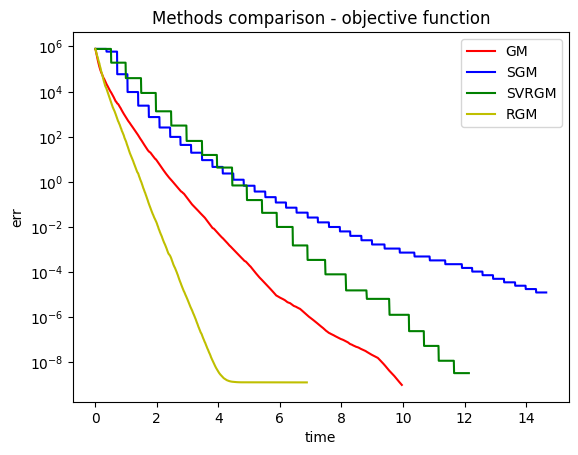

In [10]:
# Optimality tolerance
eps = 1.0e-3
# Stopping criterion
stopcr = 1

# verbosity = 0 don't display info, verbosity = 1 display info
verb = 0

# Generation of the instance
n = 2**12
m = 2**10
k = round(0.1 * n)

Q, c, xs, xsn, picks = getData(m, n, k, 0, 0)

# starting point
x1 = np.zeros((n,))

fstop = 10**-9
maxit = 2000
maxit2 = 400000
maxit3 = 400000
maxit4 = 100000
lsg = 0.0001
lcgm = np.linalg.norm(Q.T@Q)
lsvrg = 0.0001
nepochs = 10000


print("*****************")
print("*  GM STANDARD  *")
print("*****************")

xgm, itergm, fxgm, tottimegm, fhgm, timeVecgm, gnrgm = GM_ls(Q, c, x1, lcgm, verb, 3, maxit, eps, fstop, stopcr)

# Print results
print("f(x)  = {:.3e}".format(fxgm))
print("Number of iterations = {}".format(itergm))
print("||gr||^2 = {}".format(gnrgm[-1]))
print("CPU time so far = {:.3e}".format(tottimegm))

print("*****************")
print("*  SGM STANDARD *")
print("*****************")

xsgm, itersgm, fxsgm, tottimesgm, fhsgm, timeVecsgm, gnrsgm = STGM_ls(Q, c, x1, lsg, verb, nepochs, maxit2, eps, fstop, stopcr)

# Print results
print("f(x)  = {:.3e}".format(fxsgm))
print("Number of iterations = {}".format(itersgm))
print("CPU time so far = {:.3e}".format(tottimesgm))

print("*****************")
print("* SVRGM STANDARD *")
print("*****************")

xsvrgm, itersvrgm, fxsvrgm, tottimesvrgm, fhsvrgm, timeVecsvrgm, gnrsvrgm = VR_STGM_ls(Q, c, x1, lsvrg, verb, nepochs, maxit3, eps, fstop, stopcr)

# Print results
print("f(x)  = {:.3e}".format(fxsvrgm))
print("Number of iterations = {}".format(itersvrgm))
print("CPU time so far = {:.3e}".format(tottimesvrgm))

print("*****************")
print("*  RGM STANDARD *")
print("*****************")

xrgm, iterrgm, fxrgm, tottimergm, fhrgm, timeVecrgm, gnrrgm = RGM_ls(Q, c, x1, verb, 2, maxit4, eps, fstop, stopcr)

# Print results
print("f(x)  = {:.3e}".format(fxrgm))
print("Number of iterations = {}".format(iterrgm))
print("CPU time so far = {:.3e}".format(tottimergm))

# plot figure
fmin = 0.0

plt.figure()
plt.semilogy(timeVecgm, fhgm - fmin, 'r-', label='GM')
plt.semilogy(timeVecsgm, fhsgm - fmin, 'b-', label='SGM')
plt.semilogy(timeVecsvrgm, fhsvrgm - fmin, 'g-', label='SVRGM')
plt.semilogy(timeVecrgm, fhrgm - fmin, 'y-', label='RGM')

plt.title('Methods comparison - objective function')
plt.legend()
plt.xlabel('time')
plt.ylabel('err')
plt.show()

*****************
*  GM STANDARD  *
*****************
f(x)  = 1.534e+00
Number of iterations = 20000
||gr||^2 = 5.768861047869541
CPU time so far = 1.779e+01
*****************
*  SGM STANDARD *
*****************
f(x)  = 4.178e+02
Number of iterations = 400000
CPU time so far = 1.195e+01
*****************
* SVRGM STANDARD *
*****************
f(x)  = 7.414e+01
Number of iterations = 400000
CPU time so far = 1.438e+01
*****************
*  RGM STANDARD *
*****************
f(x)  = 1.437e+01
Number of iterations = 200000
CPU time so far = 1.056e+01


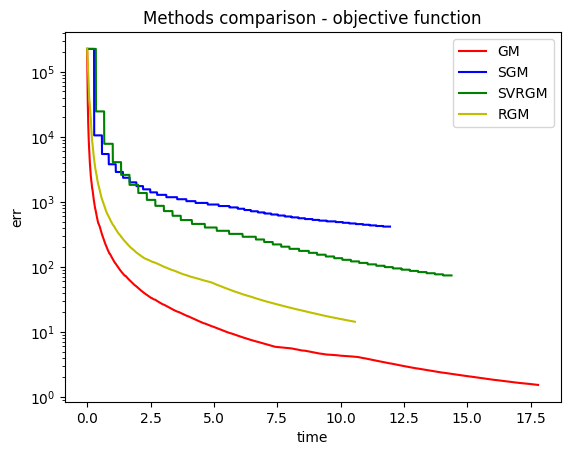

In [8]:
# Optimality tolerance
eps = 1.0e-3
# Stopping criterion
stopcr = 1

# verbosity = 0 don't display info, verbosity = 1 display info
verb = 0

# Generation of the instance
n = 2**10
m = 2**10
k = round(0.1 * n)

Q, c, xs, xsn, picks = getData(m, n, k, 0, 0)

# starting point
x1 = np.zeros((n,))

fstop = 10**-9
maxit = 20000
maxit2 = 400000
maxit3 = 400000
maxit4 = 200000
lsg = 0.0001
lcgm = np.linalg.norm(Q.T@Q)
lsvrg = 0.0001
nepochs = 10000


print("*****************")
print("*  GM STANDARD  *")
print("*****************")

xgm, itergm, fxgm, tottimegm, fhgm, timeVecgm, gnrgm = GM_ls(Q, c, x1, lcgm, verb, 3, maxit, eps, fstop, stopcr)

# Print results
print("f(x)  = {:.3e}".format(fxgm))
print("Number of iterations = {}".format(itergm))
print("||gr||^2 = {}".format(gnrgm[-1]))
print("CPU time so far = {:.3e}".format(tottimegm))

print("*****************")
print("*  SGM STANDARD *")
print("*****************")

xsgm, itersgm, fxsgm, tottimesgm, fhsgm, timeVecsgm, gnrsgm = STGM_ls(Q, c, x1, lsg, verb, nepochs, maxit2, eps, fstop, stopcr)

# Print results
print("f(x)  = {:.3e}".format(fxsgm))
print("Number of iterations = {}".format(itersgm))
print("CPU time so far = {:.3e}".format(tottimesgm))

print("*****************")
print("* SVRGM STANDARD *")
print("*****************")

xsvrgm, itersvrgm, fxsvrgm, tottimesvrgm, fhsvrgm, timeVecsvrgm, gnrsvrgm = VR_STGM_ls(Q, c, x1, lsvrg, verb, nepochs, maxit3, eps, fstop, stopcr)

# Print results
print("f(x)  = {:.3e}".format(fxsvrgm))
print("Number of iterations = {}".format(itersvrgm))
print("CPU time so far = {:.3e}".format(tottimesvrgm))

print("*****************")
print("*  RGM STANDARD *")
print("*****************")

xrgm, iterrgm, fxrgm, tottimergm, fhrgm, timeVecrgm, gnrrgm = RGM_ls(Q, c, x1, verb, 2, maxit4, eps, fstop, stopcr)

# Print results
print("f(x)  = {:.3e}".format(fxrgm))
print("Number of iterations = {}".format(iterrgm))
print("CPU time so far = {:.3e}".format(tottimergm))

# plot figure
fmin = 0.0

plt.figure()
plt.semilogy(timeVecgm, fhgm - fmin, 'r-', label='GM')
plt.semilogy(timeVecsgm, fhsgm - fmin, 'b-', label='SGM')
plt.semilogy(timeVecsvrgm, fhsvrgm - fmin, 'g-', label='SVRGM')
plt.semilogy(timeVecrgm, fhrgm - fmin, 'y-', label='RGM')

plt.title('Methods comparison - objective function')
plt.legend()
plt.xlabel('time')
plt.ylabel('err')
plt.show()

*****************
*  GM STANDARD  *
*****************
f(x)  = 2.486e+06
Number of iterations = 50
||gr||^2 = 1292364958748.915
CPU time so far = 1.822e+01
*****************
*  SGM STANDARD *
*****************
f(x)  = 6.116e-03
Number of iterations = 400000
CPU time so far = 1.924e+01
*****************
* SVRGM STANDARD *
*****************
f(x)  = 6.896e-10
Number of iterations = 210001
CPU time so far = 1.557e+01
*****************
*  RGM STANDARD *
*****************
f(x)  = 1.387e+07
Number of iterations = 1000
CPU time so far = 1.502e+01


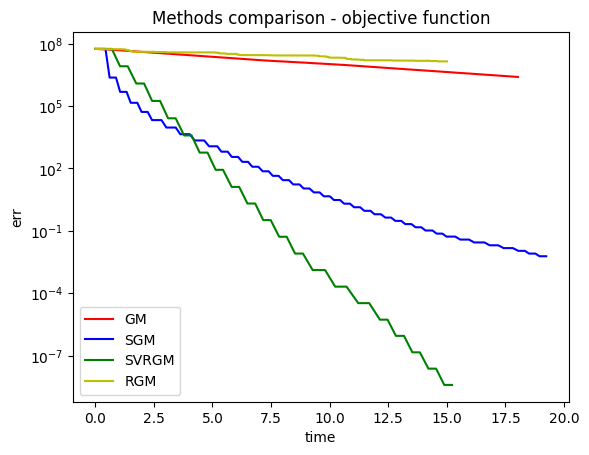

In [9]:
# Optimality tolerance
eps = 1.0e-3
# Stopping criterion
stopcr = 1

# verbosity = 0 don't display info, verbosity = 1 display info
verb = 0

# Generation of the instance
n = 2**10
m = 2**18
k = round(0.1 * n)

Q, c, xs, xsn, picks = getData(m, n, k, 0, 0)

# starting point
x1 = np.zeros((n,))

fstop = 10**-9
maxit = 50
maxit2 = 400000
maxit3 = 400000
maxit4 = 1000
lsg = 0.0001
lcgm = np.linalg.norm(Q.T@Q)
lsvrg = 0.0001
nepochs = 10000


print("*****************")
print("*  GM STANDARD  *")
print("*****************")

xgm, itergm, fxgm, tottimegm, fhgm, timeVecgm, gnrgm = GM_ls(Q, c, x1, lcgm, verb, 3, maxit, eps, fstop, stopcr)

# Print results
print("f(x)  = {:.3e}".format(fxgm))
print("Number of iterations = {}".format(itergm))
print("||gr||^2 = {}".format(gnrgm[-1]))
print("CPU time so far = {:.3e}".format(tottimegm))

print("*****************")
print("*  SGM STANDARD *")
print("*****************")

xsgm, itersgm, fxsgm, tottimesgm, fhsgm, timeVecsgm, gnrsgm = STGM_ls(Q, c, x1, lsg, verb, nepochs, maxit2, eps, fstop, stopcr)

# Print results
print("f(x)  = {:.3e}".format(fxsgm))
print("Number of iterations = {}".format(itersgm))
print("CPU time so far = {:.3e}".format(tottimesgm))

print("*****************")
print("* SVRGM STANDARD *")
print("*****************")

xsvrgm, itersvrgm, fxsvrgm, tottimesvrgm, fhsvrgm, timeVecsvrgm, gnrsvrgm = VR_STGM_ls(Q, c, x1, lsvrg, verb, nepochs, maxit3, eps, fstop, stopcr)

# Print results
print("f(x)  = {:.3e}".format(fxsvrgm))
print("Number of iterations = {}".format(itersvrgm))
print("CPU time so far = {:.3e}".format(tottimesvrgm))

print("*****************")
print("*  RGM STANDARD *")
print("*****************")

xrgm, iterrgm, fxrgm, tottimergm, fhrgm, timeVecrgm, gnrrgm = RGM_ls(Q, c, x1, verb, 2, maxit4, eps, fstop, stopcr)

# Print results
print("f(x)  = {:.3e}".format(fxrgm))
print("Number of iterations = {}".format(iterrgm))
print("CPU time so far = {:.3e}".format(tottimergm))

# plot figure
fmin = 0.0

plt.figure()
plt.semilogy(timeVecgm, fhgm - fmin, 'r-', label='GM')
plt.semilogy(timeVecsgm, fhsgm - fmin, 'b-', label='SGM')
plt.semilogy(timeVecsvrgm, fhsvrgm - fmin, 'g-', label='SVRGM')
plt.semilogy(timeVecrgm, fhrgm - fmin, 'y-', label='RGM')

plt.title('Methods comparison - objective function')
plt.legend()
plt.xlabel('time')
plt.ylabel('err')
plt.show()